<a href="https://colab.research.google.com/github/kridtapon/Volumetric-Reversal-Trail-VRT-/blob/main/Volumetric_Reversal_Trail_(VRT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00


In [1]:
pip install --upgrade yfinance

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-3-fc3ee5a12af7>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Close'][i] > df['Close'][i - 1]:
<ipython-input-3-fc3ee5a12af7>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Close'][i] < df['Close'][i - 1]:
<ipython-input-3-fc3ee5a12af7>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trh = max(df['High'][i], df['Close'][i - 1

Best Parameters:
atr_period       23.000000
stop_period      15.000000
multiplier        1.800000
total_return    702.310783
Name: 5266, dtype: float64


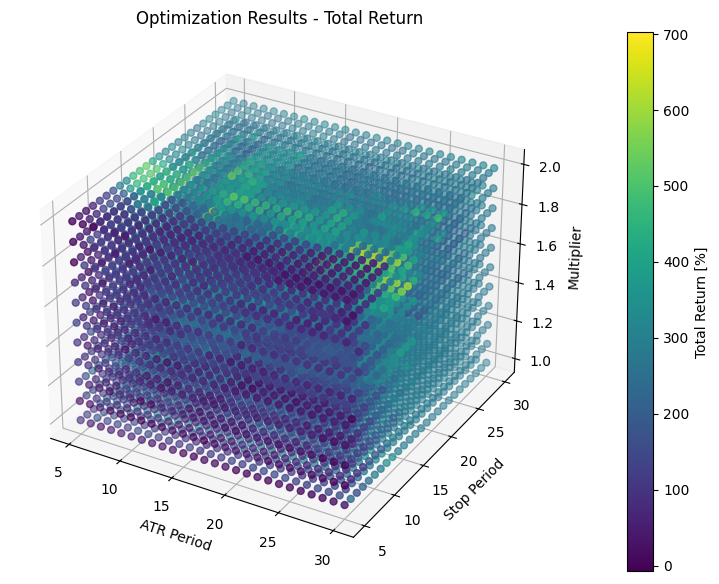

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# --- Functions ---

def calculate_wad(df):
    wad = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trl
        elif df['Close'][i] < df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trh
        else:
            ad = 0
        wad.append(wad[-1] + ad)
    return pd.Series(wad, index=df.index)

def calculate_chande_kroll(df, atr_period=10, stop_period=10, multiplier=1.5):
    tr = df['High'].combine(df['Low'], max) - df['Low'].combine(df['High'], min)
    atr = tr.rolling(window=atr_period).mean()
    high_stop = df['High'].rolling(window=stop_period).max() - multiplier * atr
    low_stop = df['Low'].rolling(window=stop_period).min() + multiplier * atr
    return high_stop, low_stop

# --- Data Download ---
symbol = 'KLAC'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Calculate WAD ---
df['WAD'] = calculate_wad(df)

# --- Define parameter grid ---
atr_range = range(5, 31)
stop_range = range(5, 31)
multiplier_range = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
param_grid = list(product(atr_range, stop_range, multiplier_range))

# --- Optimization loop ---
results = []

for atr_period, stop_period, multiplier in param_grid:
    df_temp = df.copy()

    # Chande Kroll Stop
    df_temp['CKS_High'], df_temp['CKS_Low'] = calculate_chande_kroll(df_temp, atr_period, stop_period, multiplier)

    # Signals
    df_temp['WAD_Rising'] = df_temp['WAD'] > df_temp['WAD'].shift(10)
    df_temp['WAD_Falling'] = df_temp['WAD'] < df_temp['WAD'].shift(10)

    df_temp['Entry'] = (df_temp['CKS_High'] > df_temp['CKS_Low']) & df_temp['WAD_Rising'] & (df_temp['CKS_High'] > df_temp['Close'])
    df_temp['Exit'] = (df_temp['CKS_High'] < df_temp['CKS_Low']) & df_temp['WAD_Falling'] & (df_temp['CKS_Low'] < df_temp['Close'])

    # Filter date
    df_test = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    # Shift signals
    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    # Portfolio
    try:
        portfolio = vbt.Portfolio.from_signals(
            close=df_test['Open'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )
        stats = portfolio.stats()
        total_return = stats.loc['Total Return [%]']
    except Exception as e:
        total_return = np.nan

    results.append({
        'atr_period': atr_period,
        'stop_period': stop_period,
        'multiplier': multiplier,
        'total_return': total_return
    })

# --- Find best parameters ---
results_df = pd.DataFrame(results)
best_result = results_df.sort_values(by='total_return', ascending=False).dropna().iloc[0]
print("Best Parameters:")
print(best_result)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D plot
x = results_df['atr_period']
y = results_df['stop_period']
z = results_df['multiplier']
c = results_df['total_return']

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=25)
ax.set_xlabel('ATR Period')
ax.set_ylabel('Stop Period')
ax.set_zlabel('Multiplier')
ax.set_title('Optimization Results - Total Return')

# Add color bar
cb = plt.colorbar(sc, pad=0.1)
cb.set_label('Total Return [%]')

plt.show()


In [4]:
# Calculate WAD
df['WAD'] = calculate_wad(df)

# Calculate Chande Kroll Stop
df['CKS_High'], df['CKS_Low'] = calculate_chande_kroll(df, atr_period=23, stop_period=15, multiplier=1.8)

# Define Entry and Exit signals
df['WAD_Rising'] = df['WAD'] > df['WAD'].shift(10)
df['WAD_Falling'] = df['WAD'] < df['WAD'].shift(10)

df['Entry'] = (df['CKS_High'] > df['CKS_Low']) & df['WAD_Rising'] & (df['CKS_High'] > df['Close'])
df['Exit'] = (df['CKS_High'] < df['CKS_Low']) & df['WAD_Falling'] & (df['CKS_Low'] < df['Close'])

# Filter data for the test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Print performance stats
print(portfolio.stats())

# Plot performance
portfolio.plot().show()

<ipython-input-3-fc3ee5a12af7>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Close'][i] > df['Close'][i - 1]:
<ipython-input-3-fc3ee5a12af7>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Close'][i] < df['Close'][i - 1]:
<ipython-input-3-fc3ee5a12af7>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trh = max(df['High'][i], df['Close'][i - 1])
<ipython-input-3-fc3ee5a12af7>:18: FutureWarning: Series.__getitem

Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  802310.783118
Total Return [%]                              702.310783
Benchmark Return [%]                          273.318677
Max Gross Exposure [%]                             100.0
Total Fees Paid                             14245.610473
Max Drawdown [%]                                27.49911
Max Drawdown Duration                  164 days 00:00:00
Total Trades                                          18
Total Closed Trades                                   18
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   77.777778
Best Trade [%]                                 41.811283
Worst Trade [%]                

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Williams Accumulation/Distribution (WAD)
def calculate_wad(df):
    wad = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trl
        elif df['Close'][i] < df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trh
        else:
            ad = 0
        wad.append(wad[-1] + ad)
    return pd.Series(wad, index=df.index)

# Function to calculate Chande Kroll Stop
def calculate_chande_kroll(df, atr_period=10, stop_period=10, multiplier=1.5):
    atr = df['High'].combine(df['Low'], max) - df['Low'].combine(df['High'], min)
    atr = atr.rolling(window=atr_period).mean()

    high_stop = df['High'].rolling(window=stop_period).max() - multiplier * atr
    low_stop = df['Low'].rolling(window=stop_period).min() + multiplier * atr

    return high_stop, low_stop

# Define the stock symbol and time period
symbol = 'NFLX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate WAD
df['WAD'] = calculate_wad(df)

# Calculate Chande Kroll Stop
df['CKS_High'], df['CKS_Low'] = calculate_chande_kroll(df)

# Define Entry and Exit signals
df['WAD_Rising'] = df['WAD'] > df['WAD'].shift(10)
df['WAD_Falling'] = df['WAD'] < df['WAD'].shift(10)

df['Entry'] = (df['CKS_High'] > df['CKS_Low']) & df['WAD_Rising'] & (df['CKS_High'] > df['Close'])
df['Exit'] = (df['CKS_High'] < df['CKS_Low']) & df['WAD_Falling'] & (df['CKS_Low'] < df['Close'])

# Filter data for the test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Print performance stats
print(portfolio.stats())

# Plot performance
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-89b908f62dd0>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-5-89b908f62dd0>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-5-89b908f62dd0>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-5-89b908f62dd0>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future 

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           167060.948941
Total Return [%]                        67.060949
Benchmark Return [%]                   176.540929
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4310.432375
Max Drawdown [%]                        46.147995
Max Drawdown Duration           725 days 00:00:00
Total Trades                                   18
Total Closed Trades                            18
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            66.666667
Best Trade [%]                          27.843191
Worst Trade [%]                        -36.981732
Avg Winning Trade [%]                   10.391372
Avg Losing Trade [%]                    -9.072843


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-75731b42258a>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-6-75731b42258a>:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-6-75731b42258a>:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-6-75731b42258a>:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future 

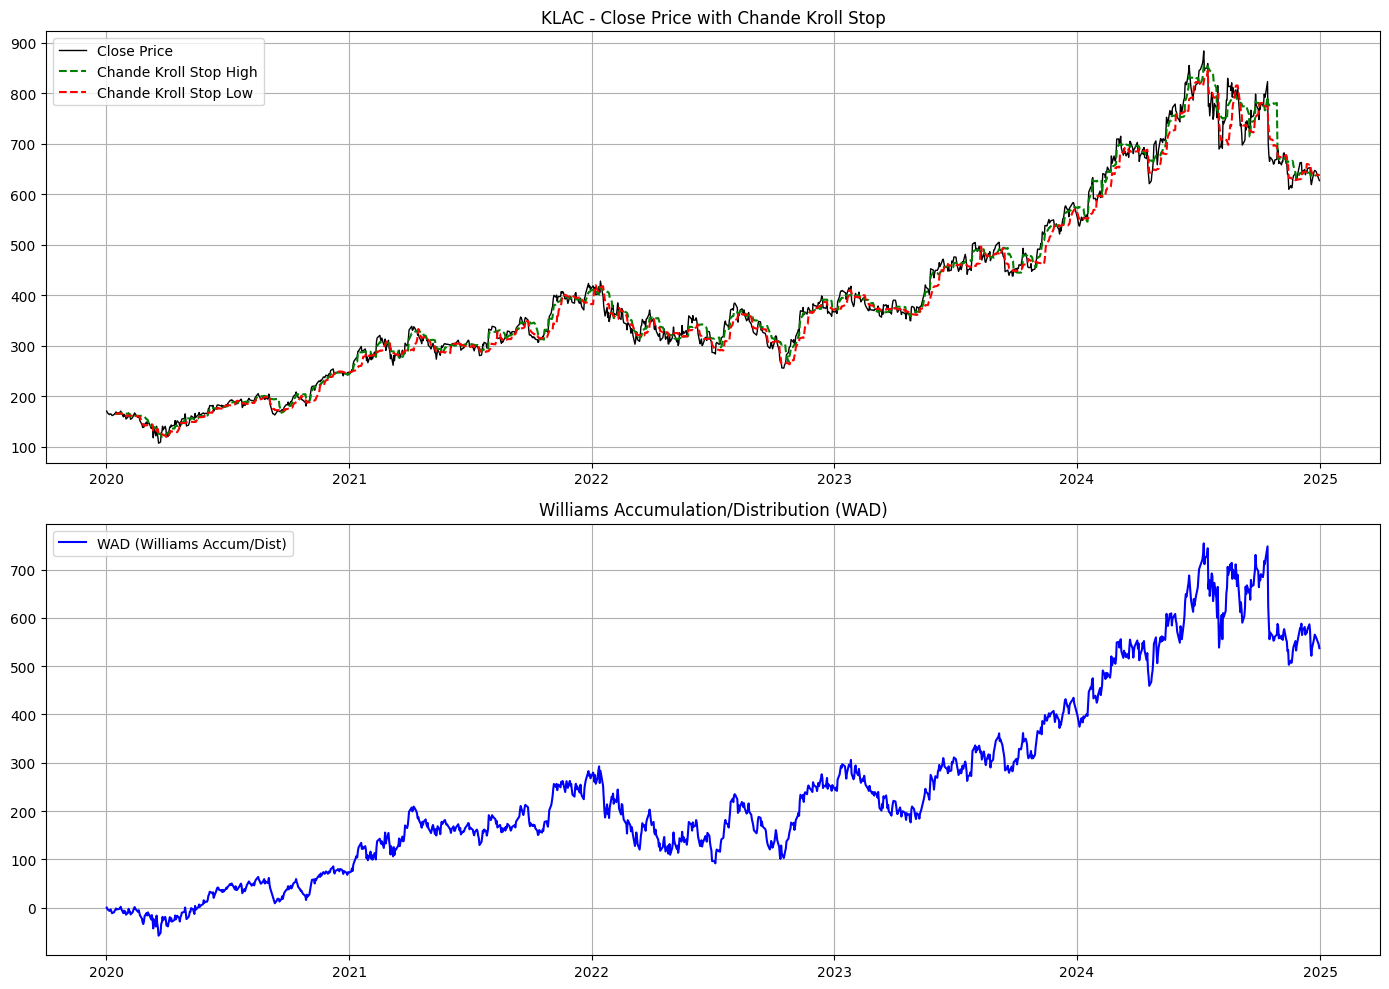

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Indicator Functions ---

# Function to calculate Williams Accumulation/Distribution (WAD)
def calculate_wad(df):
    wad = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trl
        elif df['Close'][i] < df['Close'][i - 1]:
            trh = max(df['High'][i], df['Close'][i - 1])
            trl = min(df['Low'][i], df['Close'][i - 1])
            ad = df['Close'][i] - trh
        else:
            ad = 0
        wad.append(wad[-1] + ad)
    return pd.Series(wad, index=df.index)

# Function to calculate Chande Kroll Stop
def calculate_chande_kroll(df, atr_period=10, stop_period=10, multiplier=1.5):
    atr = df['High'].combine(df['Low'], max) - df['Low'].combine(df['High'], min)
    atr = atr.rolling(window=atr_period).mean()
    high_stop = df['High'].rolling(window=stop_period).max() - multiplier * atr
    low_stop = df['Low'].rolling(window=stop_period).min() + multiplier * atr
    return high_stop, low_stop

# --- Data Download ---

symbol = 'KLAC'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Indicator Calculation ---
df['WAD'] = calculate_wad(df)
df['CKS_High'], df['CKS_Low'] = calculate_chande_kroll(df)

# --- Plotting ---
plt.figure(figsize=(14, 10))

# Price + Chande Kroll Stop
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='black', linewidth=1)
plt.plot(df['CKS_High'], label='Chande Kroll Stop High', color='green', linestyle='--')
plt.plot(df['CKS_Low'], label='Chande Kroll Stop Low', color='red', linestyle='--')
plt.title(f'{symbol} - Close Price with Chande Kroll Stop')
plt.legend()
plt.grid()

# WAD Indicator
plt.subplot(2, 1, 2)
plt.plot(df['WAD'], label='WAD (Williams Accum/Dist)', color='blue')
plt.title('Williams Accumulation/Distribution (WAD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
